In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
words = open('names.txt','r').read().splitlines()

In [48]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [49]:
len(words)

32033

In [50]:
min(len(w) for w in words)

2

In [51]:
max(len(w) for w in words)

15

In [52]:
b = {}
for w in words:
    chs = ['<s>'] + list(w) + ['<e>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [53]:
sorted(b.items(), key = lambda kv:-kv[1])[:10]

[(('n', '<e>'), 6763),
 (('a', '<e>'), 6640),
 (('a', 'n'), 5438),
 (('<s>', 'a'), 4410),
 (('e', '<e>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<s>', 'k'), 2963)]

In [54]:
import torch

In [55]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
stoi['<s>'] = 26
stoi['<e>'] = 27
itos = {i:s for s,i in stoi.items()}

In [56]:
N = torch.zeros((28,28), dtype = torch.int32)

In [57]:
for w in words:
    chs = ['<s>'] + list(w) + ['<e>']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] += 1

(-0.5, 27.5, 27.5, -0.5)

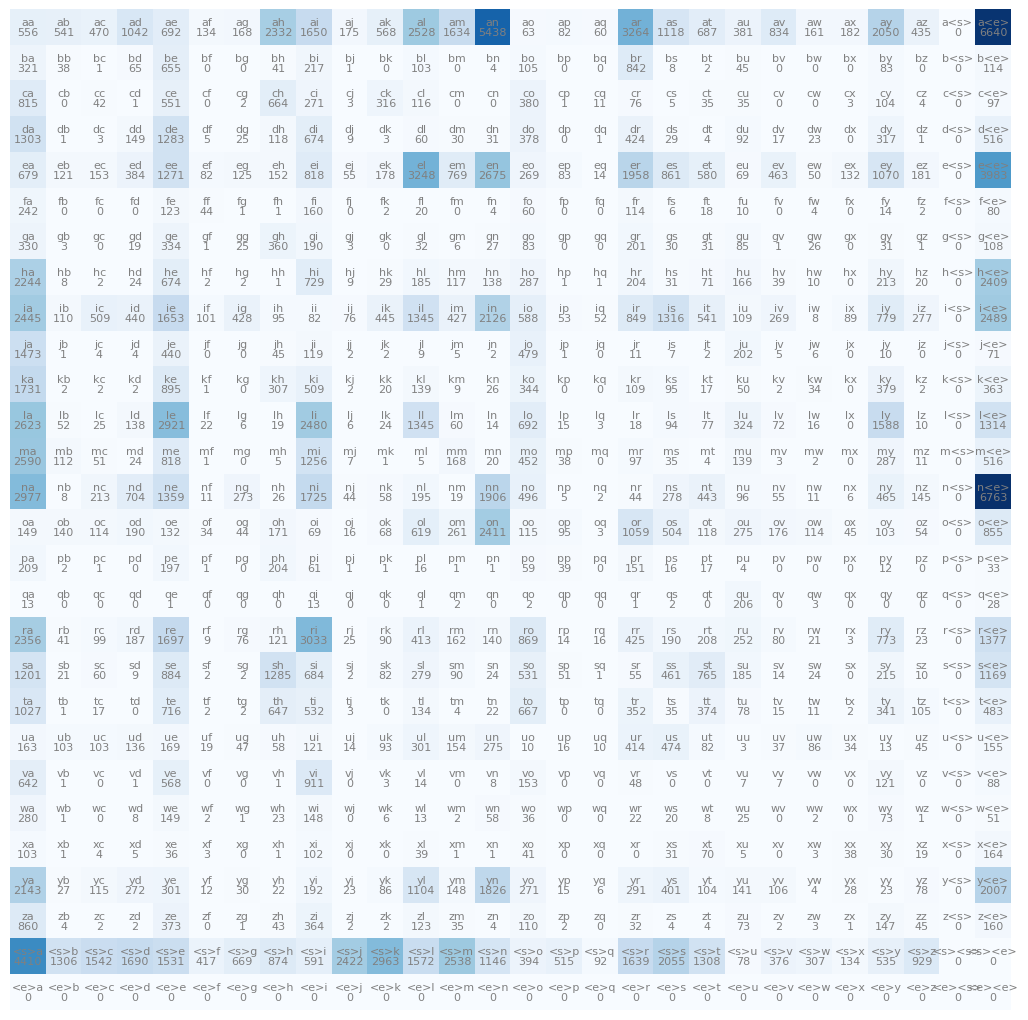

In [74]:
plt.figure(figsize=[13,13])
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = 'center', va = 'bottom', color = 'gray',fontdict={'fontsize':8})
        plt.text(j,i, N[i,j].item(), ha = 'center', va = 'top',color = 'gray',fontdict={'fontsize':8})
plt.axis('off')

More optimized

Use `.` instead of the starting and end characters used previously.

In [78]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [79]:
N = torch.zeros((27,27), dtype = torch.int32)

In [80]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1,ix2] += 1

(-0.5, 26.5, 26.5, -0.5)

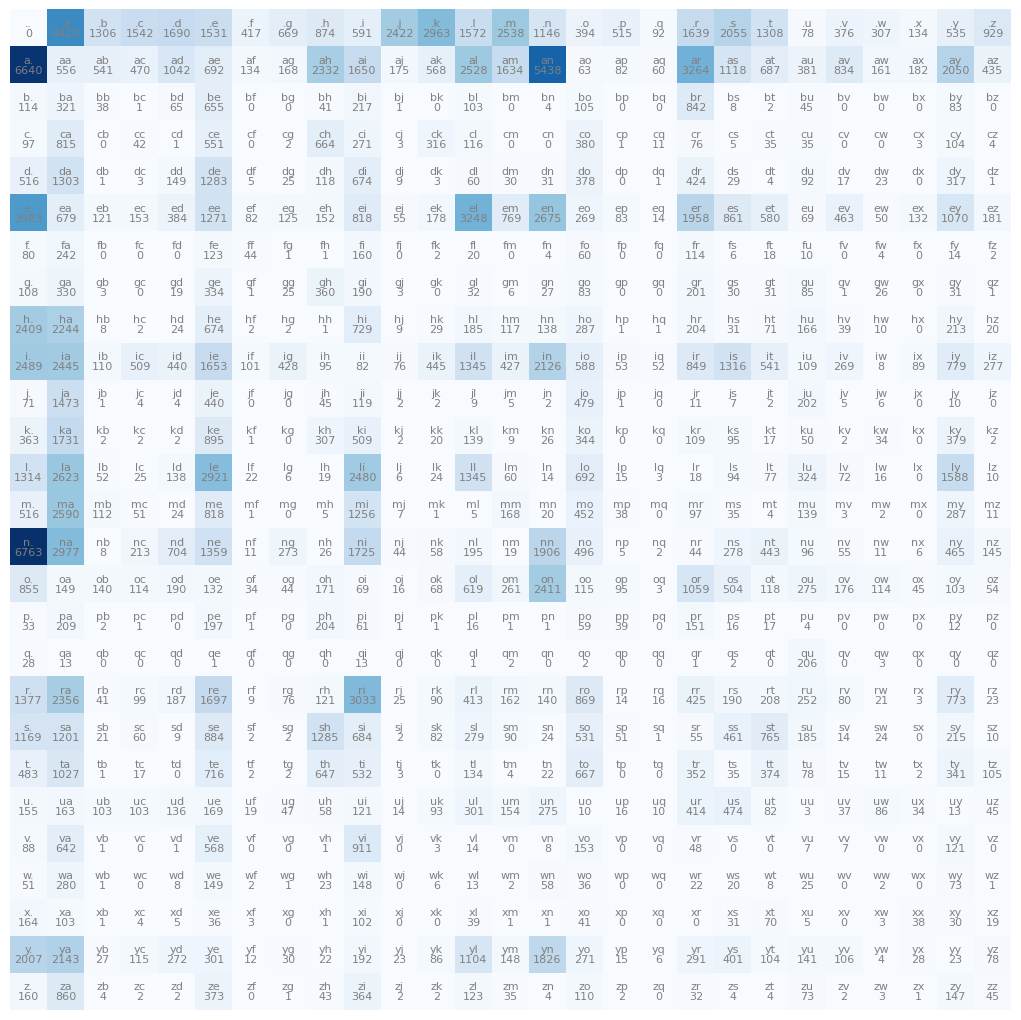

In [84]:
plt.figure(figsize=[13,13])
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha = 'center', va = 'bottom', color = 'gray',fontdict={'fontsize':8})
        plt.text(j,i, N[i,j].item(), ha = 'center', va = 'top',color = 'gray',fontdict={'fontsize':8})
plt.axis('off')

In [152]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

Convert to probabilities

In [169]:
p = N[0].float()
p = p/p.sum()
p
g  = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

In [131]:
g  = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p/p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [132]:
torch.multinomial(p, num_samples=100, replacement=True, generator=g)


tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

In [190]:
P = N.float()
P /= P.sum(dim = 1, keepdim=True)


In [191]:
g  = torch.Generator().manual_seed(2147483647)
preds = []
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, generator=g, replacement=True).item()
        out.append(itos[ix])
        if ix==0:
            break 
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


In [172]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [202]:
log_likelihood = 0.0
n = 0
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1,ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
nll = -log_likelihood
print(f'{log_likelihood=}')
print(f'{nll=}')
print(f'{nll/n}')

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299
log_likelihood=tensor(-38.7856)
nll=tensor(38.7856)
2.424102306365967
